In [1]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import pyarrow as pa
#import datetime

# Define paths
wea_files = ['LC_2022Q1.csv', 'LC_2022Q2.csv', 'LC_2022Q3.csv', 'LC_2022Q4.csv']
id_list = ['439', '440', '441', '910', '442', '443', '444', '445', '324'] # Same order as 1-9 in project.pdf

# Load with polars and remove noise stations 7 8 9
noise_loc = pl.read_csv('../noise_meta.csv')\
            .slice(0,6)
wea_loc = pl.read_csv('../01_Metadata_v2.csv')
wea_prep = pd.read_csv('out/wea_prep.csv')

In [2]:
def plot_locations(noise, wea):
    fig, ax = plt.subplots()
    ax.scatter(noise['LON'], noise['LAT'], color='red', label='Noise stations')
    ax.scatter(wea['LON'], wea['LAT'], color='blue', label='Weather stations')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    plt.show()

def loc_filter(noise, wea):
    # Find the range of longitude and latitude values in noise
    lon_min, lon_max = noise['LON'].min(), noise['LON'].max()
    lat_min, lat_max = noise['LAT'].min(), noise['LAT'].max()

    # Filter wea
    wea_filtered = wea.filter((wea['LON'] > lon_min) & (wea['LON'] < lon_max) & (wea['LAT'] > lat_min) & (wea['LAT'] < lat_max))
    
    return wea_filtered

def wea_preprocess(folder_path, files, filter):
    # Initialize empty dataframe with 1 line makes polars works
    wea_prep = pl.DataFrame({"ID":["LC-null"],"rain":["NA"],"month":[0],"day":[0],"hour":[0],"temp":["NA"]})
    for file in files:
        wea = pl.read_csv(folder_path + file, 
            columns=[1,6,12,13,14,20], 
            new_columns=['ID','rain','month','day','hour','temp'],
            infer_schema_length=1500000)
        wea = wea.filter(pl.col("ID").is_in(filter['ID'].unique().to_list()))
        
        wea_prep.extend(wea)
    
    wea_prep = wea_prep.slice(1, None)\
                    .filter(pl.col('rain') != 'NA')\
                    .filter(pl.col('temp') != 'NA')\
                    .with_columns(pl.col('rain').cast(pl.Float64, strict=False).alias('rain'))\
                    .with_columns(pl.col('temp').cast(pl.Float64, strict=False).alias('temp'))\
                    .to_pandas()
    
    # create a new column "weekend" based on the "month" and "day" columns
    wea_prep['weekend'] = pd.to_datetime('2022-' + wea_prep['month'].astype(str) + '-' + wea_prep['day'].astype(str))\
                            .dt.day_name()\
                            .apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    # Aggregate on: mean temp, max rain, per hour
    wea_prep = wea_prep.groupby(['month', 'day', 'hour', 'weekend']).agg({'temp': 'mean', 'rain': 'max'}).reset_index()
        
    return wea_prep

# Preprocess noise level with pandas
# Using output_path fixes [Errno 13]
def noise_preprocess_csv(folder_path, output_path, names):
    for name in names:
        noise = pd.DataFrame()
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv') and name in file_name:
                file_path = os.path.join(folder_path, file_name)
                add = pd.read_csv(file_path, delimiter = ';')

                add['month'] = add['result_timestamp'].str[3:5]
                add['day'] = add['result_timestamp'].str[:2]
                add['hour'] = add['result_timestamp'].str[11:13]
                add = add.groupby(['month', 'day', 'hour'])['lamax'].mean().reset_index()

                # Add the processed dataframe to the df_result dataframe
                noise = pd.concat([noise, add])

        # Export
        noise.to_csv(os.path.join(output_path, name + '.csv'), index=False)

    return 0

# Combine trainging data
def train_data(folder_path, wea, names):
    train = pd.DataFrame()
    for name in names:
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv') and name in file_name:
                file_path = os.path.join(folder_path, file_name)
                noise = pd.read_csv(file_path)
                add = pd.merge(wea, noise, on=['month', 'day', 'hour'])
                train = pd.concat([train, add])

    return train


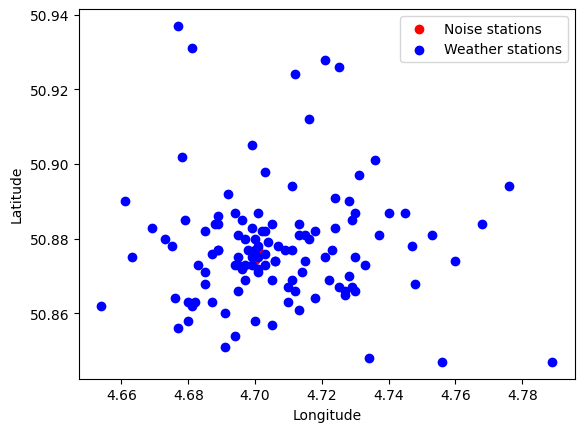

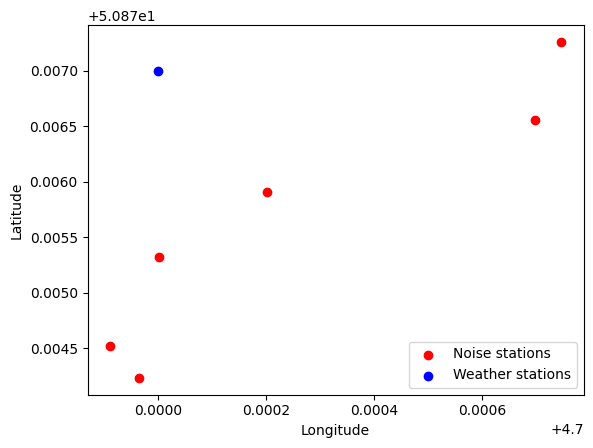

In [3]:
# Plot location of stations
plot_locations(noise_loc, wea_loc)
plot_locations(noise_loc, loc_filter(noise_loc, wea_loc))

In [4]:
wea_prep = wea_preprocess('../weather/', wea_files, loc_filter(noise_loc, wea_loc))
#wea_prep.to_csv('out/wea_prep.csv', index=False)
print(wea_prep)

      month  day  hour  weekend       temp   rain
0         1    1     0        1  13.655133  0.000
1         1    1     1        1  13.225025  0.000
2         1    1     2        1  12.918472  0.002
3         1    1     3        1  12.787498  0.000
4         1    1     4        1  12.513390  0.000
...     ...  ...   ...      ...        ...    ...
8753     12   31    19        1  16.034100  0.000
8754     12   31    20        1  16.258508  0.000
8755     12   31    21        1  16.141953  0.000
8756     12   31    22        1  16.237365  0.000
8757     12   31    23        1  16.496410  0.000

[8758 rows x 6 columns]


In [ ]:
# Takes about 10 minutes. Requires about 4Gb of RAM.
noise_preprocess_csv('../noise level/', 'out/', id_list)

In [6]:
train = train_data('out/', wea_prep, id_list)
#train.to_csv('out/train.csv', index=False)
print(train)

      month  day  hour  weekend       temp  rain      lamax
0         2   28     8        0   1.664400   0.0  58.679893
1         2   28    13        0   8.688462   0.0  57.610063
2         2   28    14        0   9.376326   0.0  57.101721
3         2   28    15        0   9.501954   0.0  56.258222
4         2   28    16        0   9.366821   0.0  57.101444
...     ...  ...   ...      ...        ...   ...        ...
6628     12   31    19        1  16.034100   0.0  49.774778
6629     12   31    20        1  16.258508   0.0  49.668556
6630     12   31    21        1  16.141953   0.0  49.956167
6631     12   31    22        1  16.237365   0.0  56.289611
6632     12   31    23        1  16.496410   0.0  59.871492

[55456 rows x 7 columns]


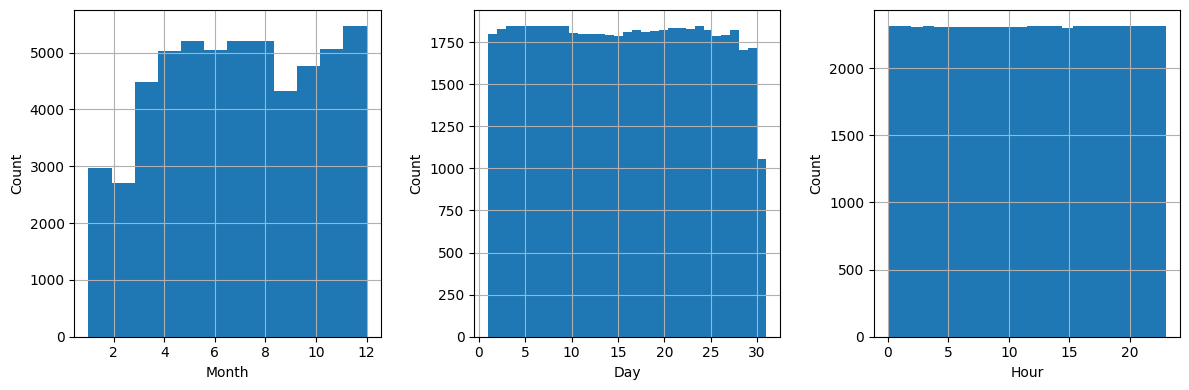

In [7]:
# Create histograms for 'month', 'day', and 'hour'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
train['month'].hist(ax=axes[0], bins=12)
train['day'].hist(ax=axes[1], bins=31)
train['hour'].hist(ax=axes[2], bins=24)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Count')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

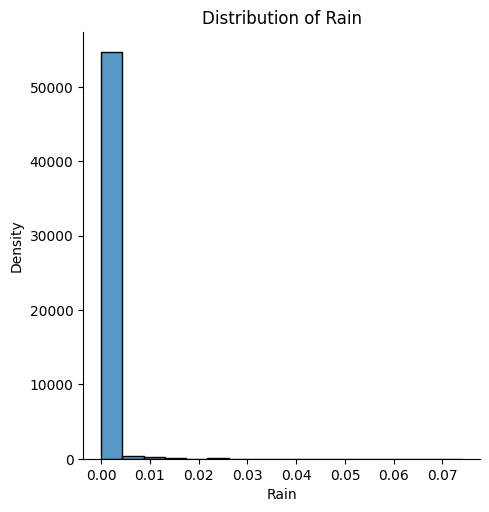

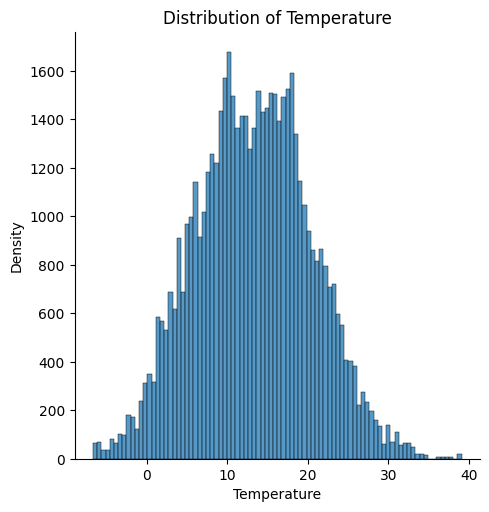

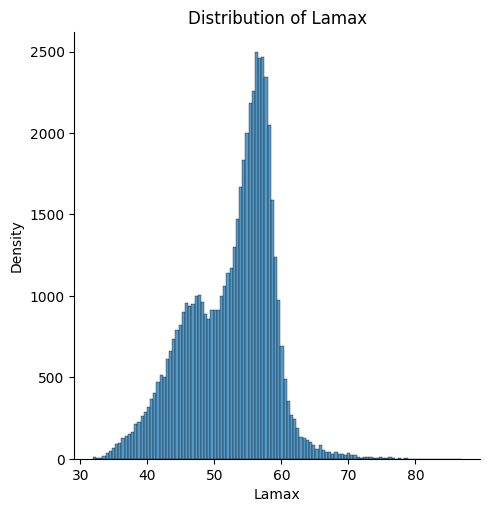

In [8]:
# Create a distribution plots for 'rain', 'temp', 'lamax'
sns.displot(train['rain'])
plt.xlabel('Rain')
plt.ylabel('Density')
plt.title('Distribution of Rain')
plt.show()

sns.displot(train['temp'])
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.title('Distribution of Temperature')
plt.show()

sns.displot(train['lamax'])
plt.xlabel('Lamax')
plt.ylabel('Density')
plt.title('Distribution of Lamax')
plt.show()

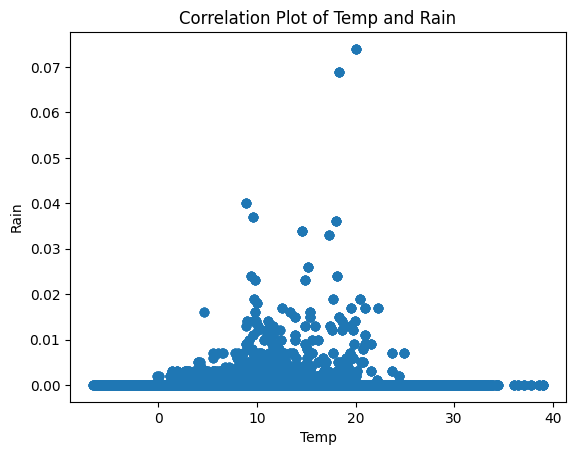

In [9]:
# Check correlation between 'temp' and 'rain'
plt.scatter(train['temp'],train['rain'])
plt.title('Correlation Plot of Temp and Rain')
plt.xlabel('Temp')
plt.ylabel('Rain')
plt.show()

In [10]:
import statsmodels.api as sm

# Define the variables
x = train[['weekend', 'rain', 'temp']]
y = train['lamax']
time = train['hour']

# Create a periodic variable using sin and cos functions of time
x['time_sin'] = np.sin(2*np.pi*time/24)
x['time_cos'] = np.cos(2*np.pi*time/24)

# Fit GLM
model = sm.GLM(y, x, family=sm.families.Gaussian())
results = model.fit()

print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  lamax   No. Observations:                55456
Model:                            GLM   Df Residuals:                    55451
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          573.85
Method:                          IRLS   Log-Likelihood:            -2.5482e+05
Date:                Sun, 07 May 2023   Deviance:                   3.1820e+07
Time:                        19:58:38   Pearson chi2:                 3.18e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             -1.539
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekend       13.7100      0.214     63.992      0.0

C:\Users\camd1\AppData\Local\Temp\ipykernel_5268\2313614352.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['time_sin'] = np.sin(2*np.pi*time/24)
C:\Users\camd1\AppData\Local\Temp\ipykernel_5268\2313614352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['time_cos'] = np.cos(2*np.pi*time/24)
